Group 13

Woramate Simrum 6422771400

Matas Thanamee 6422771251

Naphat Siriwong (ID. 6422770204)

Gorawit Khovintasets (ID. 6422771657)

Mr.Pattarit Sotyom (ID. 6422782589)

Mr. Pawarit Kongwan (ID. 64227782605)


# Import libraries and install

In [ ]:
import pandas as pd
import numpy as np
import yfinance
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
!pip install pmdarima
!pip install pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00


# 1.Data Preprocessing:

**Data Loading**

In [ ]:
data = yfinance.download(tickers="^GSPC", start="2013-02-08", end="2018-02-08", interval="1d", group_by='ticker', auto_adjust=True, threads=True)
df = pd.DataFrame(data['Close'])
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
df = df.ffill().bfill()


[*********************100%%**********************]  1 of 1 completed


**Exclude Non-Trading Days**

In [ ]:
df = df[df.index.dayofweek < 5]  # Excluding weekends

**Initial Data Checks**

In [ ]:
print("Head Data")
print(df.head())
print()
print("Tail Data")
print(df.tail())
print()
print("Info Data")
print(df.info())
print()
print("Describe Data")
print(df.describe())
print()
print("Check There are any Null Data left")
print(df.isnull().sum())


Head Data
                  Close
Date                   
2013-02-08  1517.930054
2013-02-11  1517.010010
2013-02-12  1519.430054
2013-02-13  1520.329956
2013-02-14  1521.380005

Tail Data
                  Close
Date                   
2018-02-01  2821.979980
2018-02-02  2762.129883
2018-02-05  2648.939941
2018-02-06  2695.139893
2018-02-07  2681.659912

Info Data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1304 entries, 2013-02-08 to 2018-02-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1304 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB
None

Describe Data
             Close
count  1304.000000
mean   2062.866748
std     284.167284
min    1487.849976
25%    1877.067474
50%    2060.989990
75%    2183.915100
max    2872.870117

Check There are any Null Data left
Close    0
dtype: int64


**Initial Data Visualization**

<Axes: title={'center': 'Initial Plot of S&P 500 Closing Prices'}, xlabel='Date'>

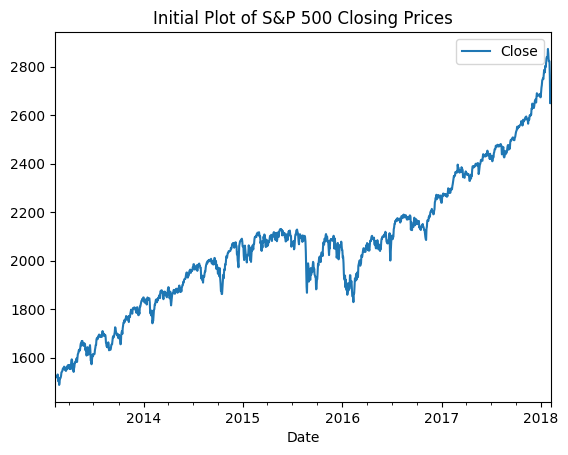

In [ ]:
df.plot(title='Initial Plot of S&P 500 Closing Prices')


**Data Transformation (Log Transformation)**

<Axes: title={'center': 'Log Transformed S&P 500 Closing Prices'}, xlabel='Date'>

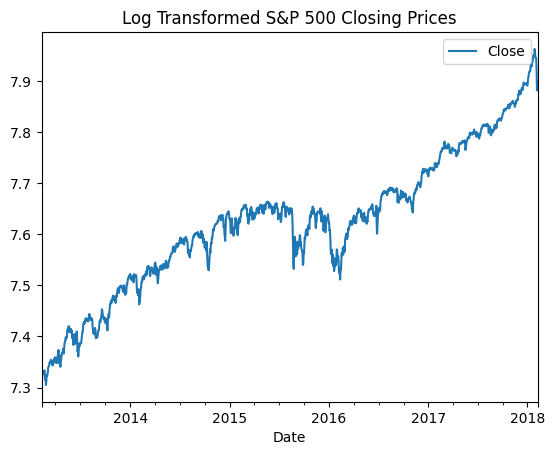

In [ ]:
df['Close'] = np.log(df['Close'])  # Applying log transformation
df.plot(title='Log Transformed S&P 500 Closing Prices')


**Advanced Visualization for Distribution and Seasonality**

Seasonality Checks


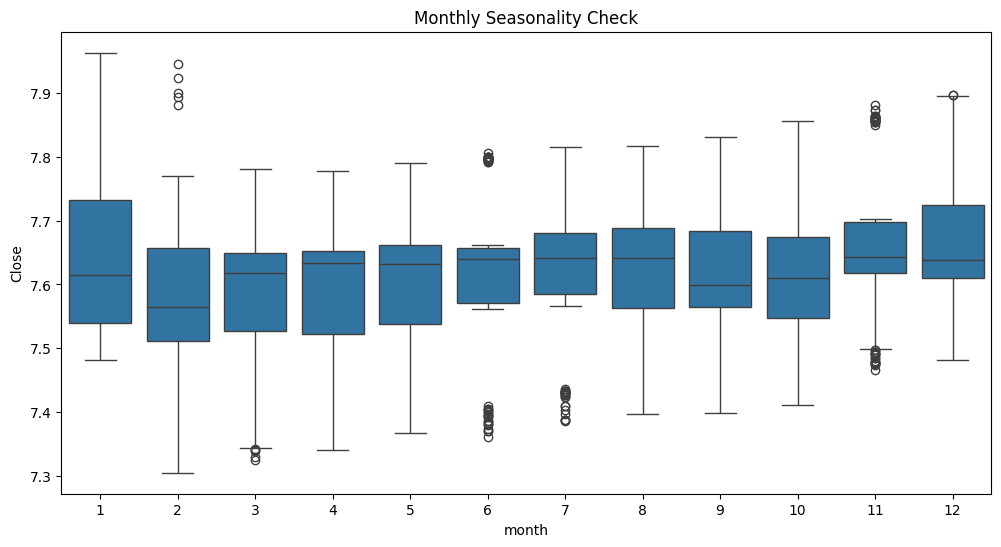

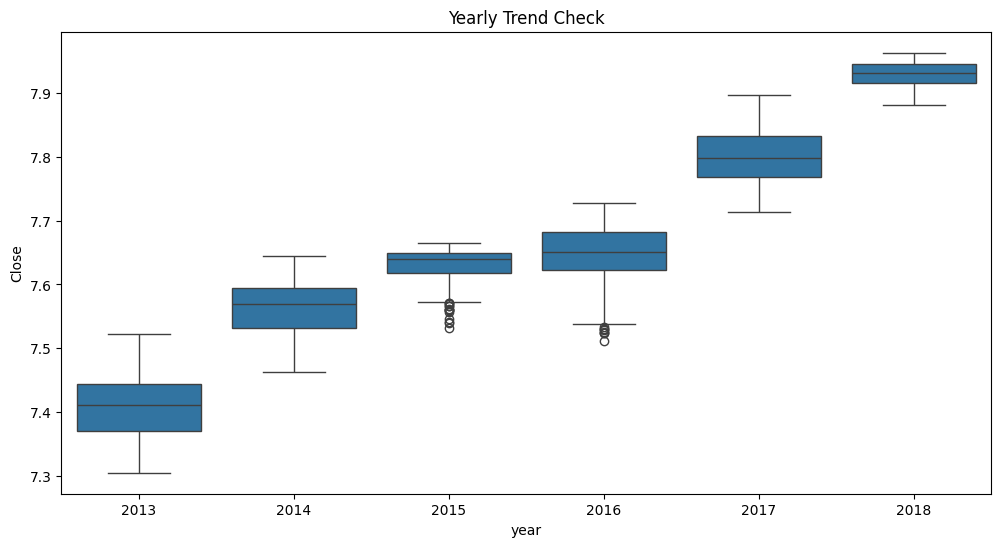


Distribution


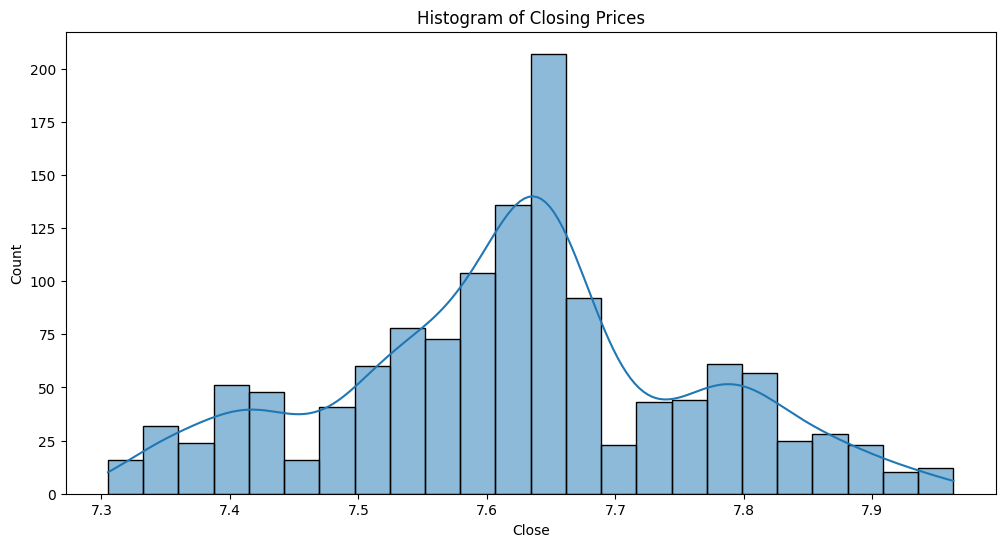

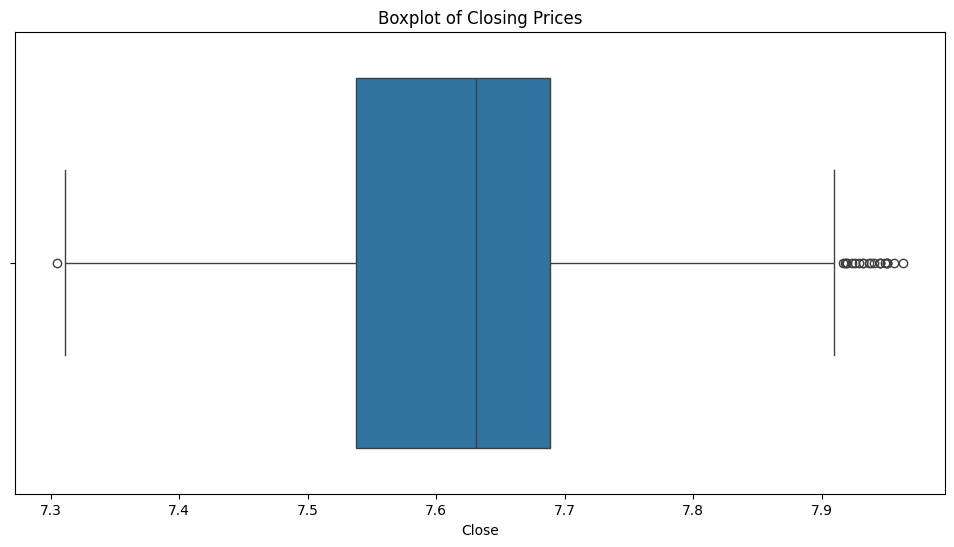

In [ ]:
# Extracting month and year for more granular plots
df['year'] = df.index.year
df['month'] = df.index.month

# Seasonality Checks
print("Seasonality Checks")
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='Close', data=df)
plt.title('Monthly Seasonality Check')
plt.show()
print()

plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='Close', data=df)
plt.title('Yearly Trend Check')
plt.show()
print()

# Distribution
print("Distribution")
plt.figure(figsize=(12, 6))
sns.histplot(df['Close'], kde=True)
plt.title('Histogram of Closing Prices')
plt.show()
print()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Close'])
plt.title('Boxplot of Closing Prices')
plt.show()


**Fetch and Prepare Exogenous Data GDP Growth Data of (US) for ARIMAX model and SARIMAX model for using as economic indicators**

In [ ]:
import pandas as pd
from pandas_datareader import wb

# Fetch GDP Growth Data
indicator_id = 'NY.GDP.MKTP.KD.ZG'  # GDP growth (annual %)
country_ids = ['USA']  # USA GDP data
start_year = 2013
end_year = 2018

gdp_growth = wb.download(indicator=indicator_id, country=country_ids, start=start_year, end=end_year)
gdp_growth.reset_index(inplace=True)
gdp_growth['year'] = pd.to_datetime(gdp_growth['year']).dt.year
gdp_growth.set_index('year', inplace=True)
gdp_growth.rename(columns={indicator_id: 'GDP Growth (%)'}, inplace=True)

# Merge GDP growth data into the main DataFrame
df['year'] = df.index.year
df = df.merge(gdp_growth, how='left', left_on='year', right_index=True)
df['GDP Growth (%)'] = df['GDP Growth (%)'].ffill()  # Forward fill missing GDP data

print(df.head())
print(df.tail())


               Close  year  month        country  GDP Growth (%)
Date                                                            
2013-02-08  7.325103  2013      2  United States         2.11783
2013-02-11  7.324497  2013      2  United States         2.11783
2013-02-12  7.326091  2013      2  United States         2.11783
2013-02-13  7.326683  2013      2  United States         2.11783
2013-02-14  7.327373  2013      2  United States         2.11783
               Close  year  month        country  GDP Growth (%)
Date                                                            
2018-02-01  7.945194  2018      2  United States        2.966505
2018-02-02  7.923757  2018      2  United States        2.966505
2018-02-05  7.881915  2018      2  United States        2.966505
2018-02-06  7.899205  2018      2  United States        2.966505
2018-02-07  7.894191  2018      2  United States        2.966505


This involves fetching and preparing the GDP growth data from the World Bank, which serves as an exogenous variable for the SARIMAX model. The GDP growth data, indicating annual percentage changes, provides a macroeconomic perspective that could potentially influence S&P 500 stock market movements. Here's a summary of the prepared data:

   GDP Growth (%)

year              
2013                "1.842"

2014                "2.526"

2015                "2.908"

2016                "1.637"

2017                "2.369"

2018                "2.927"

**Train/Test Split**

In [ ]:
# Split into train and test sets

train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [ ]:
print(len(train))
print(len(test))

1043
261


In [ ]:
print(train.head())
print(test.head())

               Close  year  month        country  GDP Growth (%)
Date                                                            
2013-02-08  7.325103  2013      2  United States         2.11783
2013-02-11  7.324497  2013      2  United States         2.11783
2013-02-12  7.326091  2013      2  United States         2.11783
2013-02-13  7.326683  2013      2  United States         2.11783
2013-02-14  7.327373  2013      2  United States         2.11783
               Close  year  month        country  GDP Growth (%)
Date                                                            
2017-02-08  7.738344  2017      2  United States        2.457622
2017-02-09  7.744080  2017      2  United States        2.457622
2017-02-10  7.747640  2017      2  United States        2.457622
2017-02-13  7.752872  2017      2  United States        2.457622
2017-02-14  7.756872  2017      2  United States        2.457622


**Initial Data Checks Again**

In [ ]:
print("Head Data")
print(df.head())
print()
print("Tail Data")
print(df.tail())
print()
print("Info Data")
print(df.info())
print()
print("Describe Data")
print(df.describe())
print()
print("Check There are any Null Data left")
print(df.isnull().sum())


Head Data
               Close  year  month        country  GDP Growth (%)
Date                                                            
2013-02-08  7.325103  2013      2  United States         2.11783
2013-02-11  7.324497  2013      2  United States         2.11783
2013-02-12  7.326091  2013      2  United States         2.11783
2013-02-13  7.326683  2013      2  United States         2.11783
2013-02-14  7.327373  2013      2  United States         2.11783

Tail Data
               Close  year  month        country  GDP Growth (%)
Date                                                            
2018-02-01  7.945194  2018      2  United States        2.966505
2018-02-02  7.923757  2018      2  United States        2.966505
2018-02-05  7.881915  2018      2  United States        2.966505
2018-02-06  7.899205  2018      2  United States        2.966505
2018-02-07  7.894191  2018      2  United States        2.966505

Info Data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1304 

# 2 Naive Forecasting Models (Benchmarks):

<ipython-input-13-c932455dd456>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_forecast'] = train['Close'].iloc[-1]
<ipython-input-13-c932455dd456>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['SMA'] = train['Close'].rolling(window=window).mean()
<ipython-input-13-c932455dd456>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

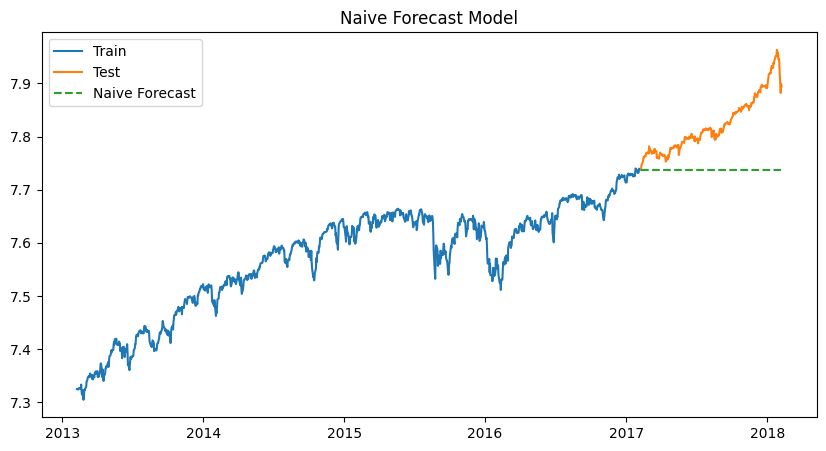

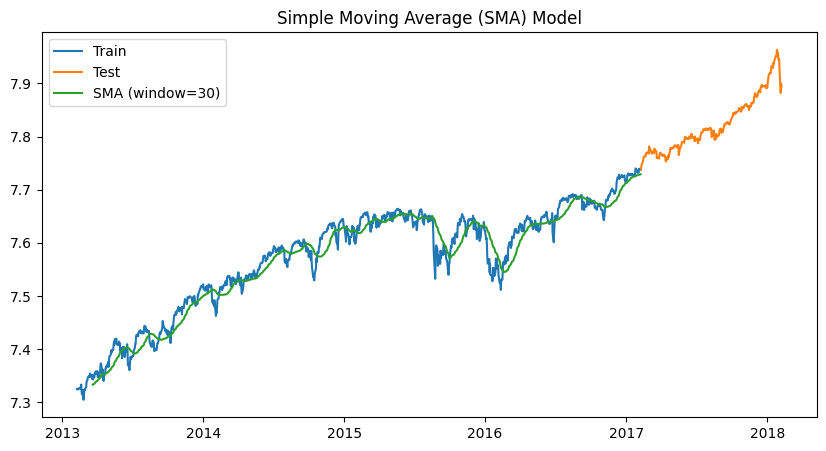

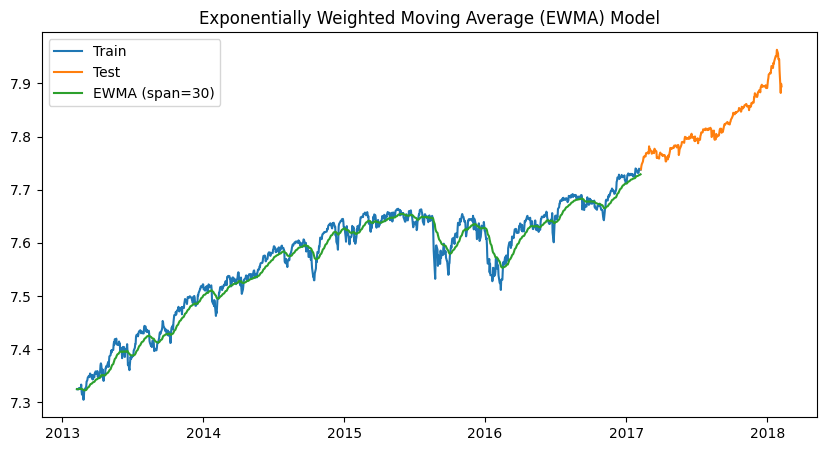

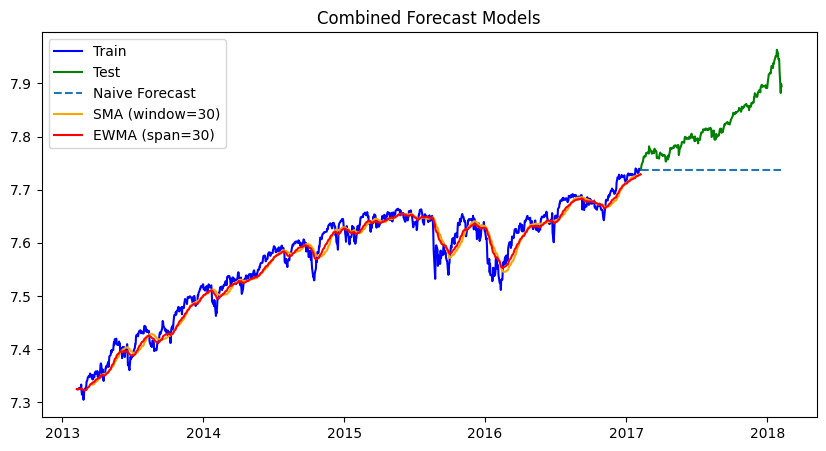

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt




# Implementing Naive Forecast model
test['naive_forecast'] = train['Close'].iloc[-1]

# Implementing Simple Moving Average (SMA)
window = 30
train['SMA'] = train['Close'].rolling(window=window).mean()

# Implementing Exponentially Weighted Moving Average (EWMA)
span = 30
train['EWMA'] = train['Close'].ewm(span=span, adjust=False).mean()

# Plot Naive Forecast
plt.figure(figsize=(10, 5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(test['naive_forecast'], label='Naive Forecast', linestyle='--')
plt.legend()
plt.title('Naive Forecast Model')
plt.show()

# Plot SMA
plt.figure(figsize=(10, 5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(train['SMA'], label=f'SMA (window={window})')
plt.legend()
plt.title('Simple Moving Average (SMA) Model')
plt.show()

# Plot EWMA
plt.figure(figsize=(10, 5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(train['EWMA'], label=f'EWMA (span={span})')
plt.legend()
plt.title('Exponentially Weighted Moving Average (EWMA) Model')
plt.show()

# Plot combined graph
plt.figure(figsize=(10, 5))
plt.plot(train['Close'], label='Train', color='blue')
plt.plot(test['Close'], label='Test', color='green')
plt.plot(test['naive_forecast'], label='Naive Forecast', linestyle='--')
plt.plot(train['SMA'], label=f'SMA (window={window})', color='orange')
plt.plot(train['EWMA'], label=f'EWMA (span={span})', color='red')
plt.legend()
plt.title('Combined Forecast Models')
plt.show()


#  3.Holt-Winters Model:

Additive Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


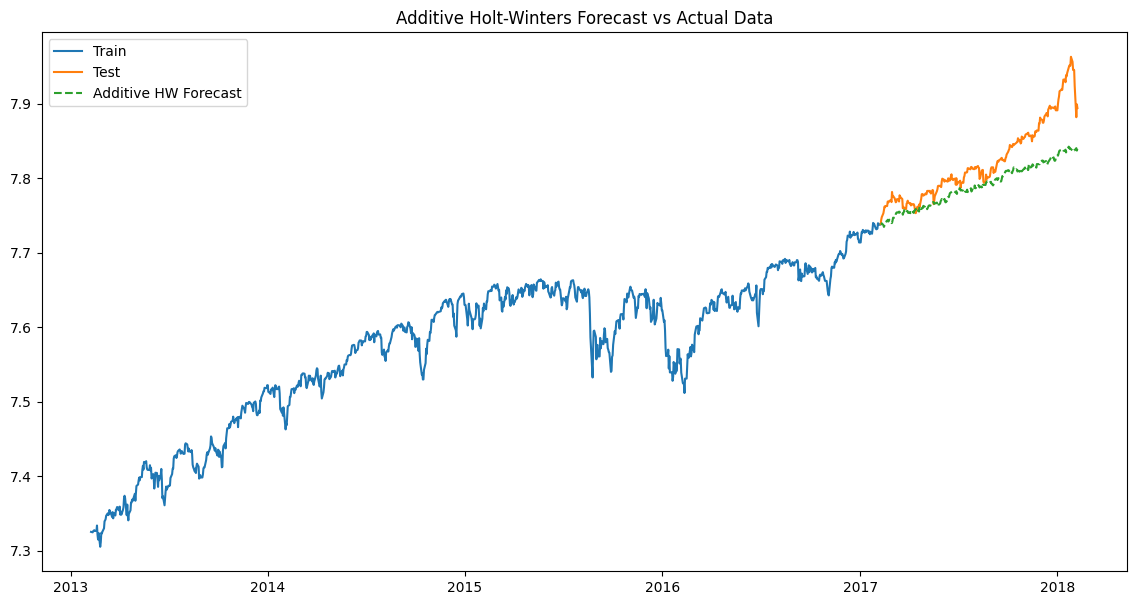

Additive Model RMSE: 0.042288208142027585
Additive Model MAE: 0.03311314292243308


In [ ]:
# Fit the model
hw_add = ExponentialSmoothing(train['Close'], seasonal_periods=72, trend='add', seasonal='add').fit()

# Forecast on the test set
add_forecast = hw_add.forecast(len(test))

# Plotting the forecasts
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, add_forecast, label='Additive HW Forecast', linestyle='--')
plt.title('Additive Holt-Winters Forecast vs Actual Data')
plt.legend()
plt.show()

# Evaluation
rmse_add = np.sqrt(mean_squared_error(test['Close'], add_forecast))
mae_add = mean_absolute_error(test['Close'], add_forecast)
print(f'Additive Model RMSE: {rmse_add}')
print(f'Additive Model MAE: {mae_add}')


**Multiplicative Model**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


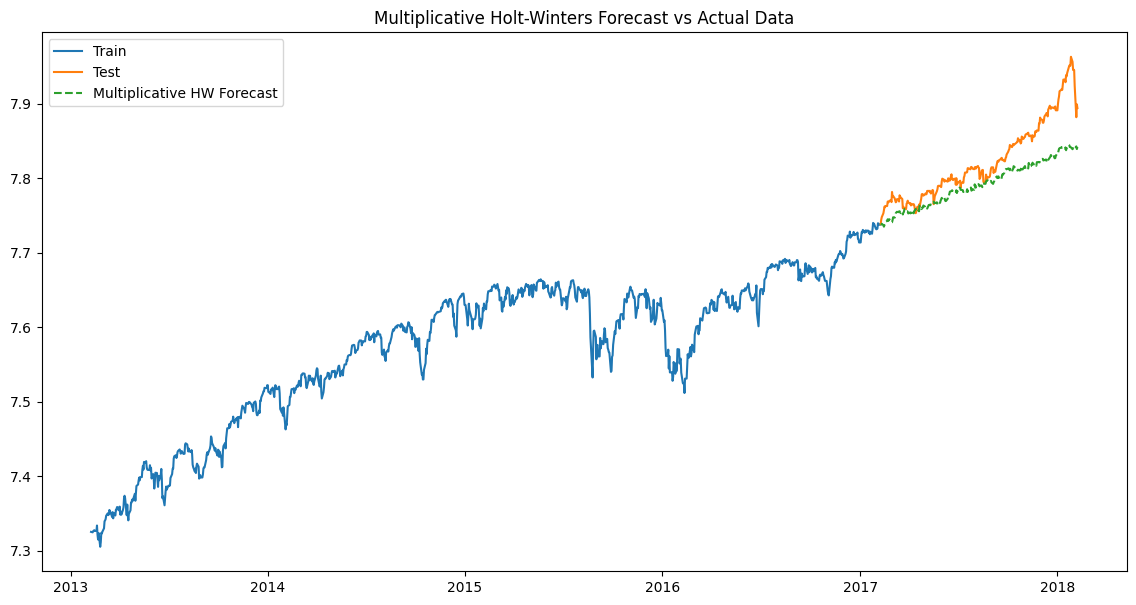

Multiplicative Model RMSE: 0.040700827722050574
Multiplicative Model MAE: 0.03165739078185038


In [ ]:
# Fit the model
hw_mul = ExponentialSmoothing(train['Close'], seasonal_periods=72, trend='add', seasonal='mul').fit()

# Forecast on the test set
mul_forecast = hw_mul.forecast(len(test))

# Plotting the forecasts
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, mul_forecast, label='Multiplicative HW Forecast', linestyle='--')
plt.title('Multiplicative Holt-Winters Forecast vs Actual Data')
plt.legend()
plt.show()

# Evaluation
rmse_mul = np.sqrt(mean_squared_error(test['Close'], mul_forecast))
mae_mul = mean_absolute_error(test['Close'], mul_forecast)
print(f'Multiplicative Model RMSE: {rmse_mul}')
print(f'Multiplicative Model MAE: {mae_mul}')


# 4.ARIMA Model:

**Test for Stationarity :**

Perform an Augmented Dickey-Fuller (ADF) test to determine if the series is stationary. If not, find the appropriate order of differencing.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is not stationary. Differencing is needed.")
        return False
    else:
        print("Series is stationary. No further differencing is needed.")
        return True

is_stationary = test_stationarity(df.Close.dropna())



ADF Statistic: -1.1807383926845467
p-value: 0.6818262061216931
Series is not stationary. Differencing is needed.


**Differencing :**

The series is not stationary, apply differencing and re-check stationarity.

In [ ]:
# Apply first differencing
df['Differenced'] = df['Close'].diff().dropna()

# Explicitly remove any rows with NaN values before passing to the test_stationarity function
df.dropna(inplace=True)  # Ensures all NaN entries are removed

# Check if the 'Differenced' column still contains NaN values
print(df['Differenced'].isnull().sum())

# Now perform the stationarity test
is_stationary = test_stationarity(df['Differenced'])


0
ADF Statistic: -36.66434818664024
p-value: 0.0
Series is stationary. No further differencing is needed.


Or this one

In [ ]:
if not is_stationary:
    # Double-checking if data still contains NaN or infinite values
    if df['Differenced'].isnull().any() or np.isinf(df['Differenced']).any():
        raise ValueError("Data still contains NaN or infinite values after differencing.")
    else:
        is_stationary = test_stationarity(df['Differenced'])
    d = 1  # Starting with first difference
else:
    d = 0


ACF and PACF Plots :
 ACF and PACF plots to determine the AR (p) and MA (q) components.

**Autocorrelation Function (ACF)**

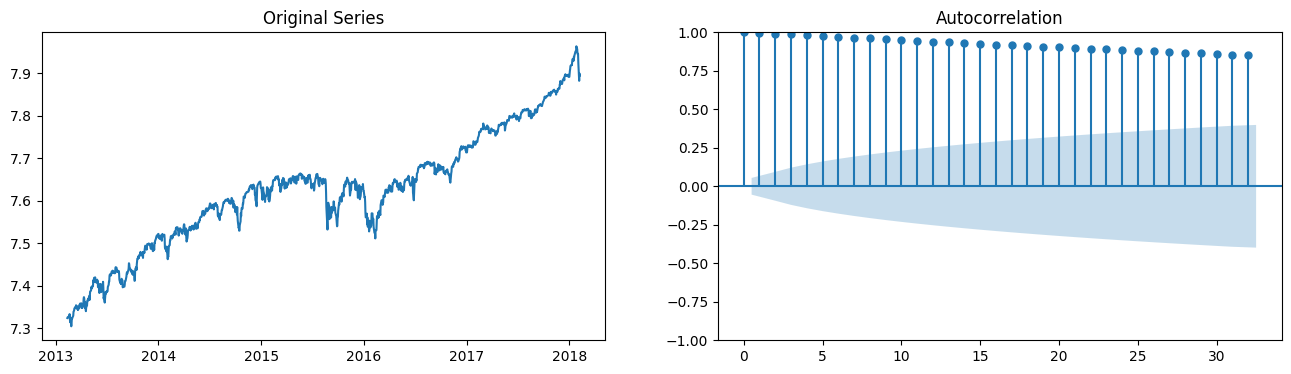

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title('Original Series')
plot_acf(df.Close.dropna(), ax=ax2);
plt.show()

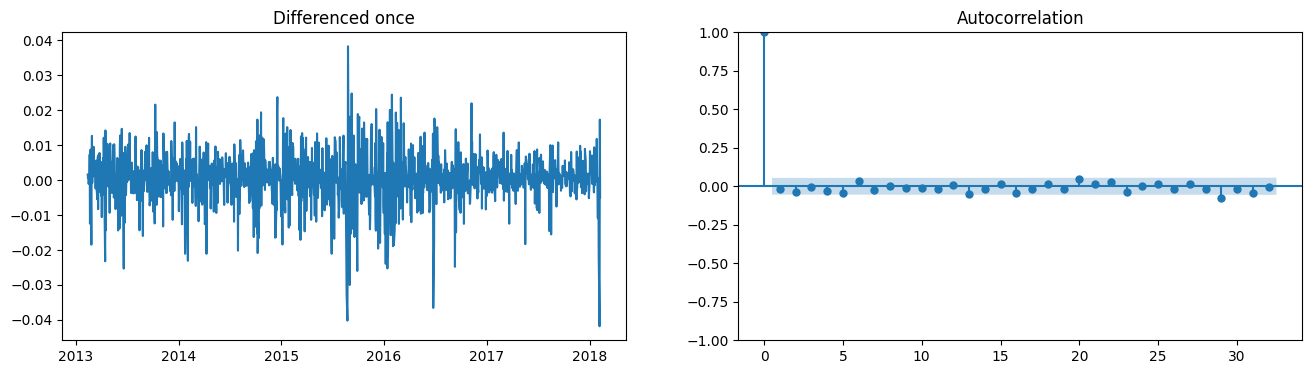

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Differenced once')
plot_acf(diff, ax=ax2);

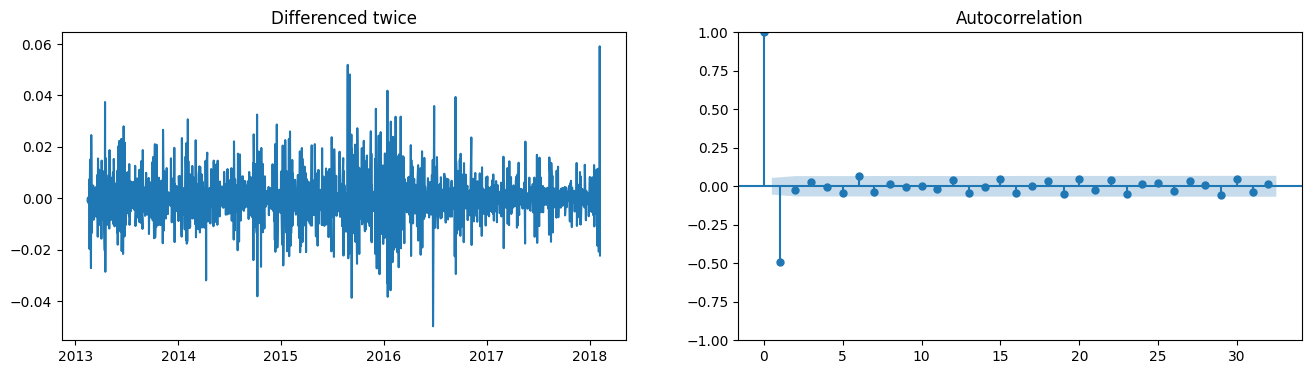

In [ ]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Differenced twice')
plot_acf(diff, ax=ax2);

Check Suitable p or Recommendation p

In [ ]:
from pmdarima.arima.utils import ndiffs
ndiffs(df.Close.dropna(), test='adf')

1

**p**

p os the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags.

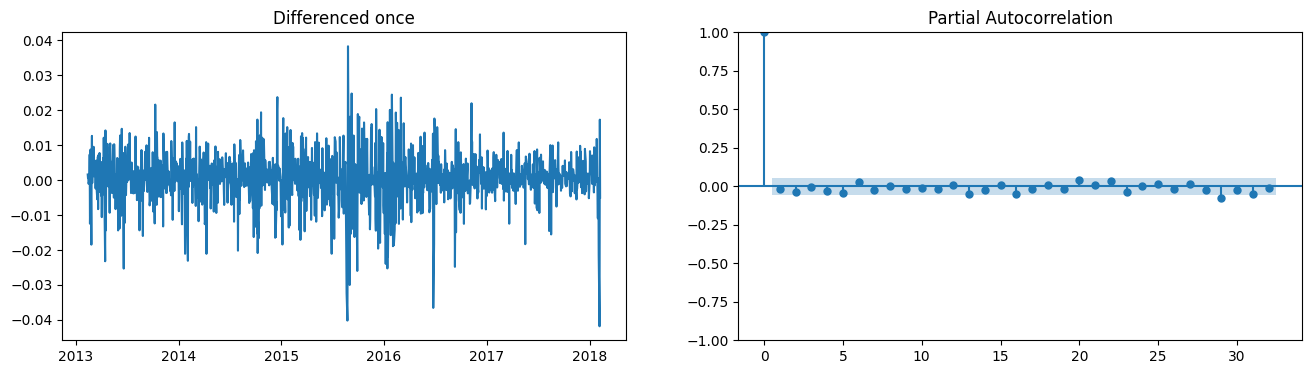

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Differenced once')
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

We can observe that the PACF lag 29 is significant as it's above the significance line.

**q**

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms

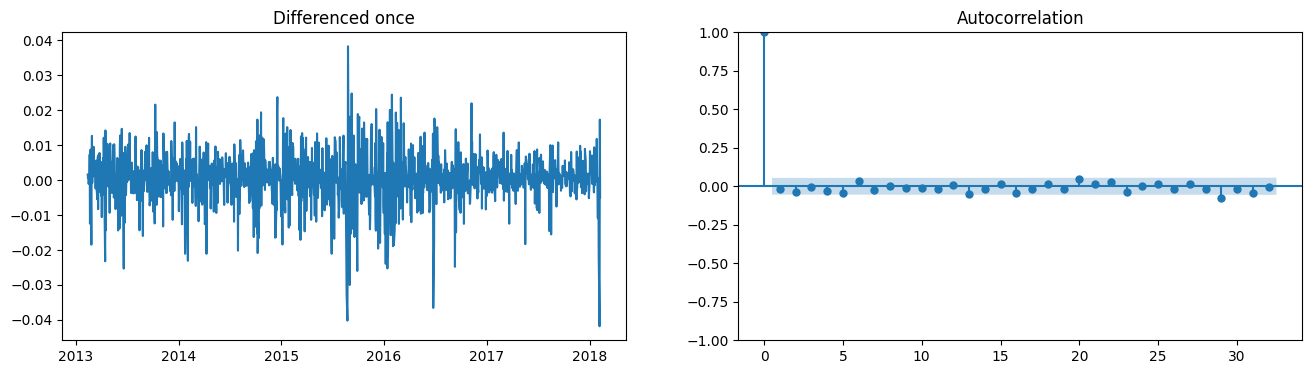

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Differenced once')
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

We can observe that the ACF lag 2 maybe significant as it's a little bit above the significance line.

**Fit ARIMA Model :**

Select initial p and q based on the ACF and PACF plots (p where PACF cuts off, q where ACF cuts off).

In [ ]:
p = 29  # Placeholder, adjust based on PACF plot
q = 2   # Placeholder, adjust based on ACF plot
d = 1   # Placeholder, adjust based on stationarity test

from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (p,d,q)
model = ARIMA(df.Close, order=(p, d, q))
results = model.fit()
print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1303
Model:                ARIMA(29, 1, 2)   Log Likelihood                4538.676
Date:                Thu, 27 Jun 2024   AIC                          -9013.352
Time:                        23:52:14   BIC                          -8847.859
Sample:                    02-11-2013   HQIC                         -8951.264
                         - 02-07-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0030      0.396     -0.007      0.994      -0.779       0.773
ar.L2         -0.0157      0.389     -0.040      0.968      -0.779       0.747
ar.L3         -0.0117      0.025     -0.474      0.6

Text(0.5, 1.0, 'Histogram of Residuals')

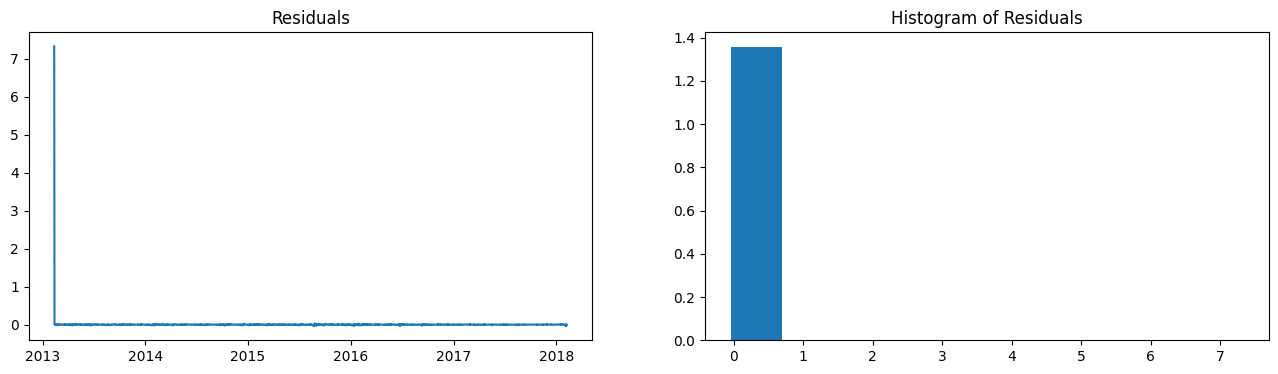

In [ ]:
#Plot residual errors
residuals = pd.DataFrame(results.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax1.set_title('Residuals')
ax2.hist(residuals, density=True)
ax2.set_title('Histogram of Residuals')


Step 5: Evaluate Model and Plot Forecasts : evaluate the model's performance and plot the forecasts against actual data.

<ipython-input-19-2584dea1209e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA Forecast'] = forecast


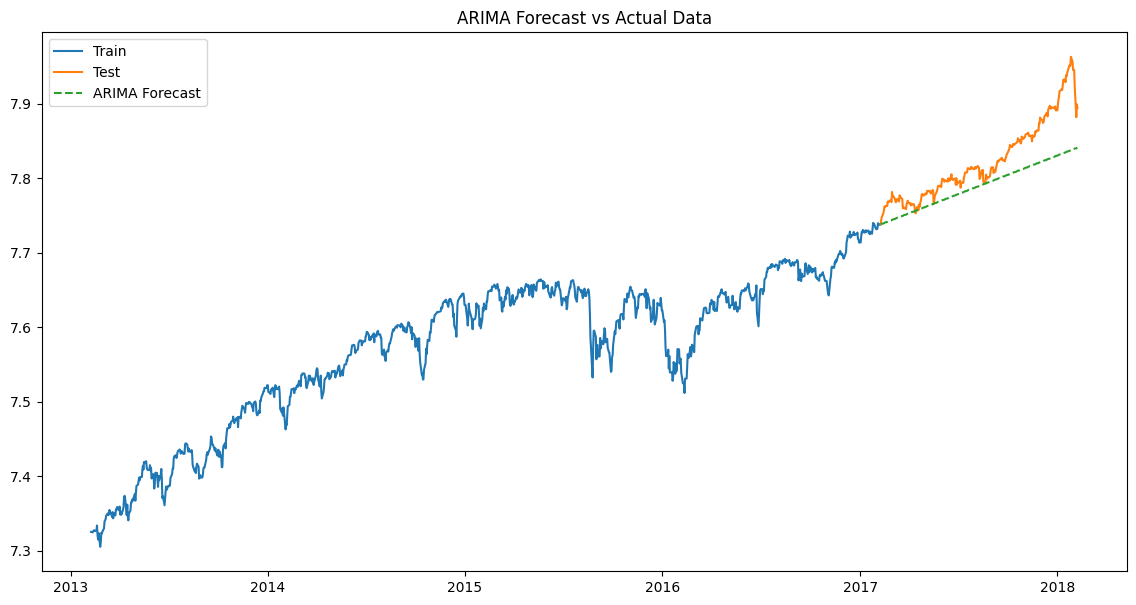

ARIMA Model RMSE: 0.04249947140515052
ARIMA Model MAE: 0.03350923302377456


In [ ]:


# Fit auto_arima model
auto_model = pm.auto_arima(train['Close'], seasonal=True, m=12)

# Forecast
forecast = auto_model.predict(n_periods=len(test))
test['ARIMA Forecast'] = forecast



# Plotting the forecasts
plt.figure(figsize=(14, 7))
plt.plot(train.index, train.Close, label='Train')
plt.plot(test.index, test.Close, label='Test')
plt.plot(test.index, test['ARIMA Forecast'], label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actual Data')
plt.legend()
plt.show()


rmse_arima = np.sqrt(mean_squared_error(test['Close'], test['ARIMA Forecast']))
mae_arima = mean_absolute_error(test['Close'], test['ARIMA Forecast'])
print(f'ARIMA Model RMSE: {rmse_arima}')
print(f'ARIMA Model MAE: {mae_arima}')

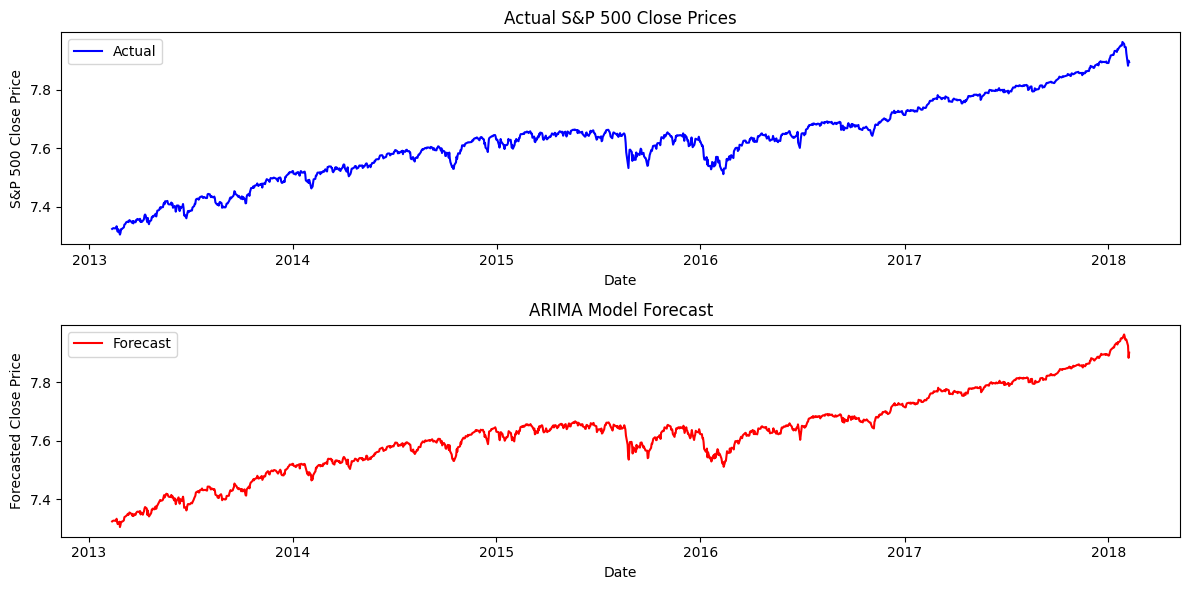

Mean Squared Error: 5.4911465065828455e-05


In [ ]:
# Predictions and in-sample fit
df['forecast'] = results.predict(start=1, end=len(df), dynamic=False)

# Plot the series and the forecast
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # First plot
plt.plot(df['Close'], label='Actual', color='blue')
plt.title('Actual S&P 500 Close Prices')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()

plt.subplot(2, 1, 2)  # Second plot
plt.plot(df['forecast'], label='Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Forecasted Close Price')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate the performance
mse = mean_squared_error(df['Close'][1:], df['forecast'][1:])
print(f'Mean Squared Error: {mse}')


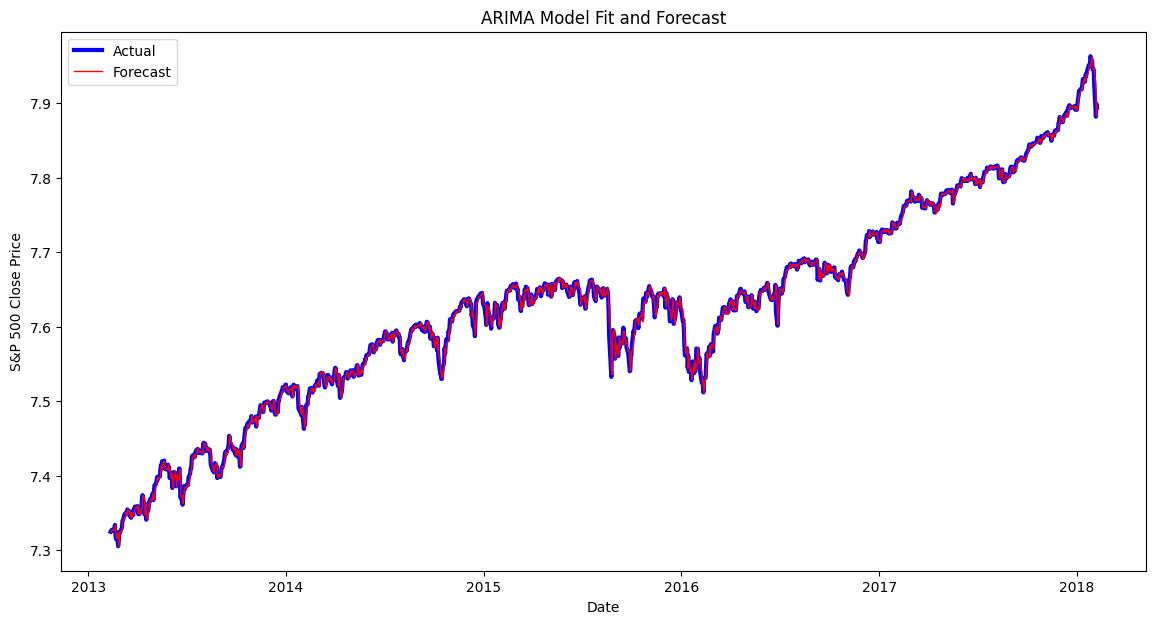

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Actual', color='blue', linestyle='-', linewidth=3)
plt.plot(df['forecast'], label='Forecast', color='red', linestyle='-', linewidth=1)
# plt.plot(df['forecast'], 'r.', label='Forecast')  # Using dots for forecast
plt.title('ARIMA Model Fit and Forecast')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()


# 5.ARIMAX

**Identify Exogenous Variables**

For the ARIMAX model, an exogenous variable must directly relate to the endogenous variable, which in this case is the S&P 500 closing prices. As suggested, GDP growth is a robust choice for this model, assuming economic growth impacts the stock market.

**Fit the ARIMAX Model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define and fit the ARIMAX model
model = SARIMAX(train['Close'], exog=train['GDP Growth (%)'], order=(1, 1, 1))
results = model.fit(disp=False)

# Display model summary
print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1042
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3557.238
Date:                Thu, 27 Jun 2024   AIC                          -7106.477
Time:                        23:52:28   BIC                          -7086.685
Sample:                    02-11-2013   HQIC                         -7098.969
                         - 02-07-2017                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
GDP Growth (%)  1.759e-07      0.194   9.05e-07      1.000      -0.381       0.381
ar.L1              0.5954      0.783      0.760      0.447      -0.939       2.130
ma.L1             -0.6093      0.772

**Evaluate the Model's Performance and Plot the Forecasts**

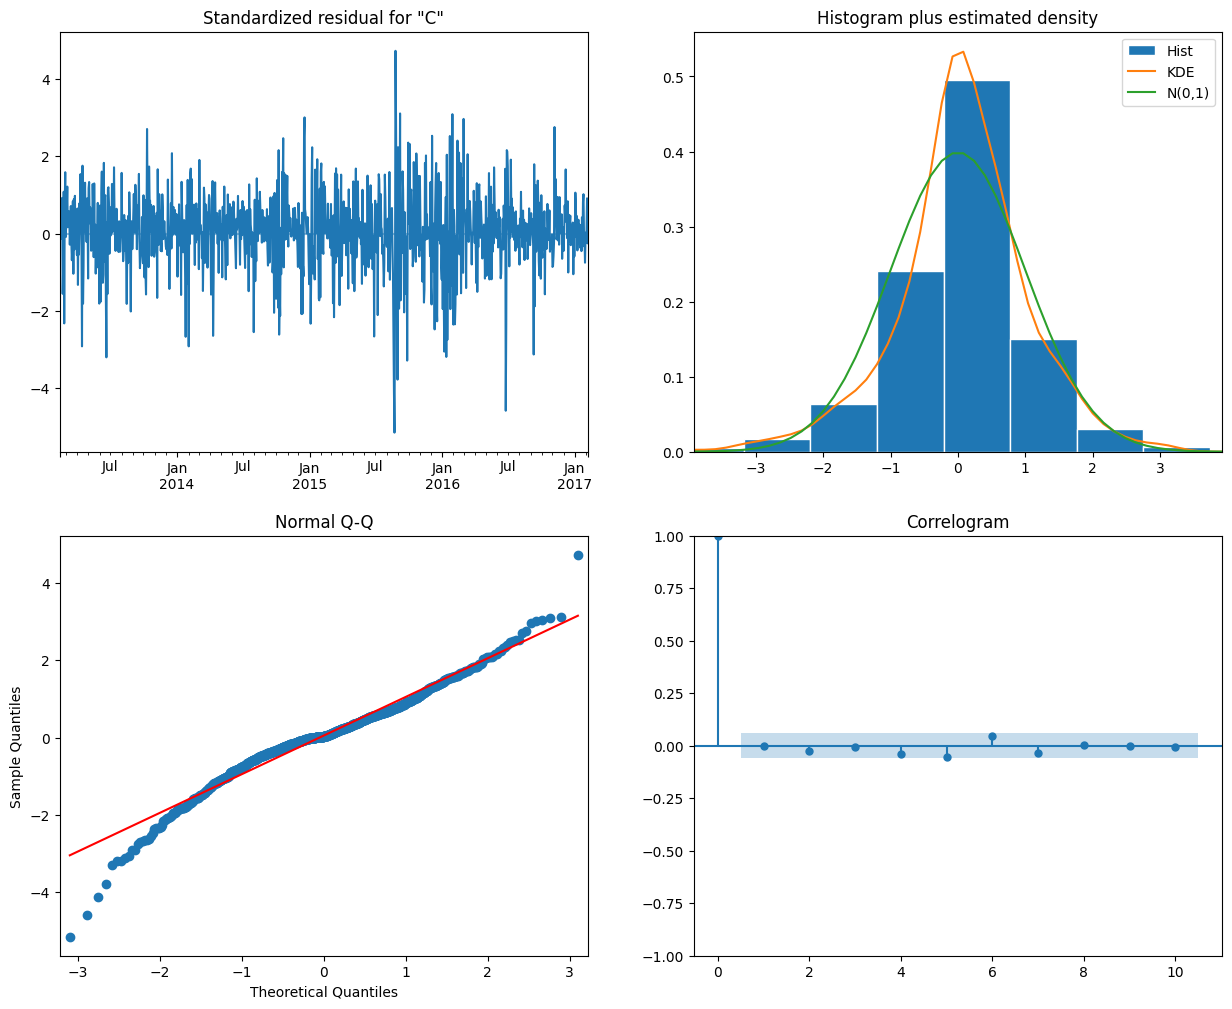

In [ ]:
# Diagnostic plots to check model adequacy
results.plot_diagnostics(figsize=(15, 12))
plt.show()
print()

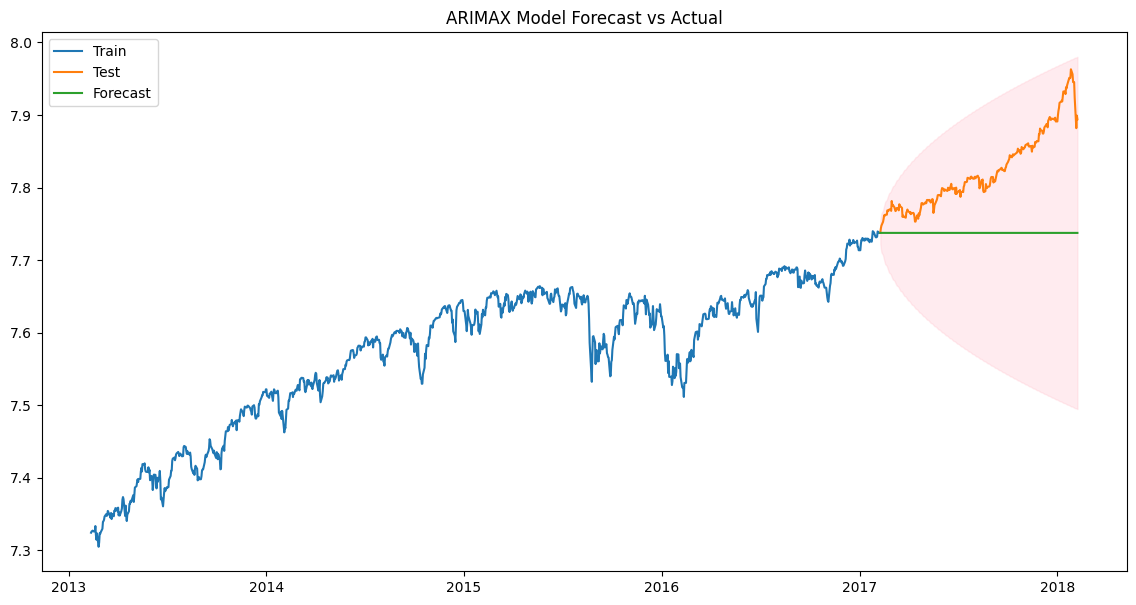

RMSE: 0.1002709676850008
MAE: 0.08536559306556431


In [ ]:
# Forecast
exog_forecast = test['GDP Growth (%)']  # Exogenous variable for the forecast
forecast = results.get_forecast(steps=len(test), exog=exog_forecast)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMAX Model Forecast vs Actual')
plt.legend()
plt.show()

# Performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(test['Close'], mean_forecast))
mae = mean_absolute_error(test['Close'], mean_forecast)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# 6.SARIMA

**Identifying Seasonality**

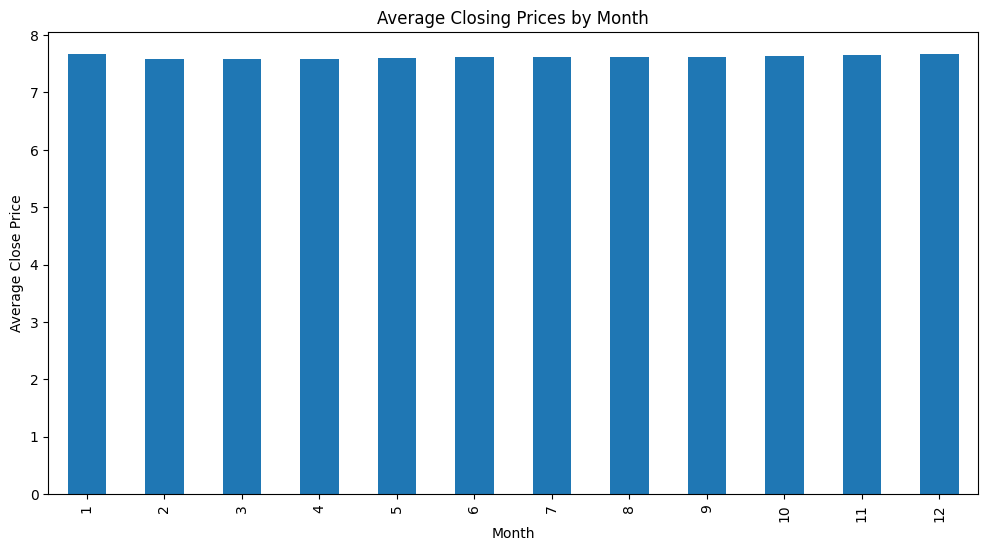

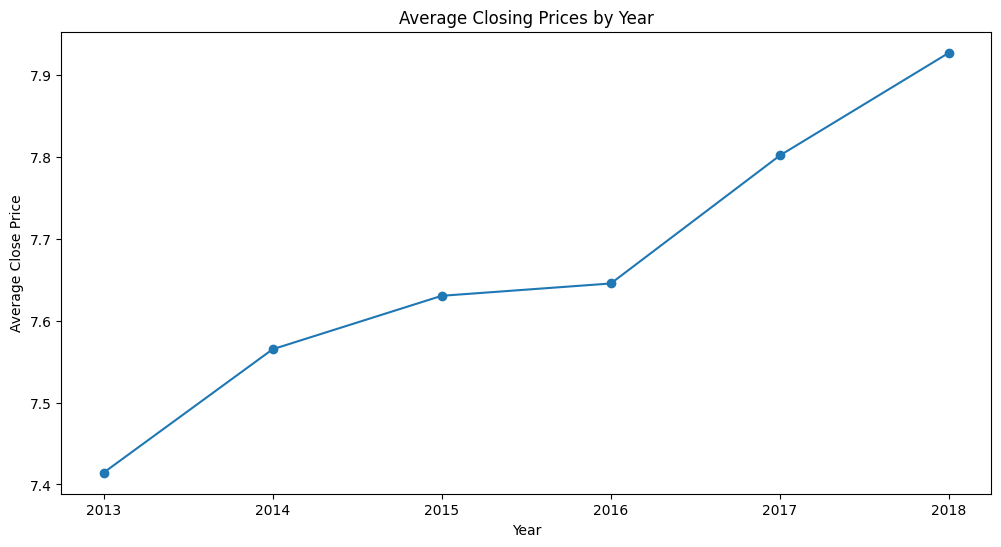

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Assuming 'df' DataFrame with the S&P 500 closing prices
df['year'] = df.index.year
df['month'] = df.index.month

# Monthly Seasonality Check
monthly_avg = df.groupby('month')['Close'].mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar')
plt.title('Average Closing Prices by Month')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.show()

# Yearly Trend Check
yearly_avg = df.groupby('year')['Close'].mean()
plt.figure(figsize=(12, 6))
yearly_avg.plot(kind='line', marker='o')
plt.title('Average Closing Prices by Year')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.show()


**Monthly Average Closing Prices by Month:**
*   The bar chart appears relatively flat, indicating little to no obvious monthly seasonality in the data. The variations between months are minimal, suggesting that the average closing price does not significantly change from one month to another in a consistent seasonal pattern.


**Yearly Average Closing Prices by Year:**
*   The line chart shows a clear upward trend over the years. This trend is critical and indicates that while there might not be strong seasonal patterns within each year, there is a significant year-over-year growth in the S&P 500 closing prices.





**ACF and PACF Analysis**

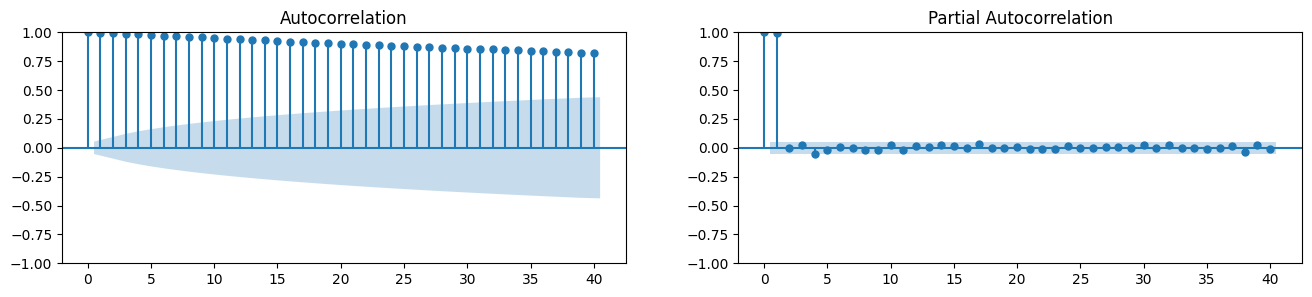

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
plot_acf(df['Close'], lags=40, ax=axes[0])  # Observing autocorrelations up to 40 lags
plot_pacf(df['Close'], lags=40, method='ywm', ax=axes[1])  # Using partial autocorrelation
plt.show()


**ACF and PACF Analysis Results:**

*   Autocorrelation Function (ACF): Shows a gradual decline, which is typical of a non-stationary series. This suggests that differencing (integrating order, d) might be required to make the series stationary.
*   Partial Autocorrelation Function (PACF): Drops off sharply after the first lag, suggesting that a first-order autoregressive term (p=1) might be sufficient.




**Fit the SARIMA Model**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1042
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                3445.106
Date:                            Thu, 27 Jun 2024   AIC                          -6880.213
Time:                                    23:52:36   BIC                          -6855.600
Sample:                                02-11-2013   HQIC                         -6870.865
                                     - 02-07-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0474      0.859      0.055      0.956      -1.636       1.731
ma.L1         -0.0719      0.854   

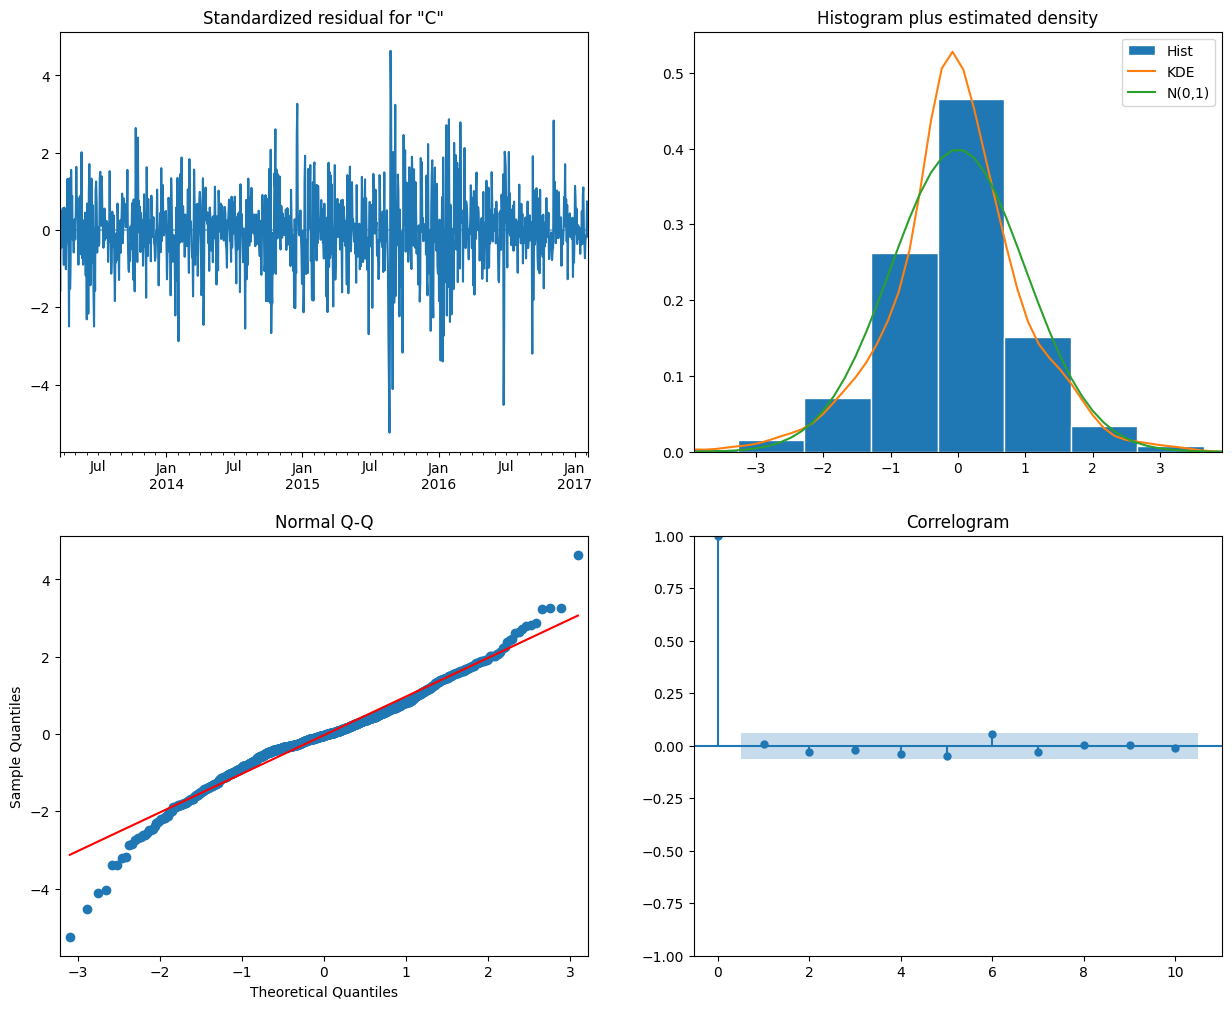

In [ ]:
# Define the model with adjusted parameters
model = SARIMAX(train['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False,enforce_invertibility=False)

# Fit the model
results = model.fit(disp=False)  # Turn off messages if the output is verbose

# Summary of the model
print(results.summary())
print()

# Diagnostic plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()
print()



**SARIMA Model**

*   Model Parameters: The AR.L1, MA.L1, and MA.S.L12 coefficients are shown along with their standard errors, z-values, and p-values. Notably, the MA.S.L12 coefficient has a significant p-value (< 0.05), indicating its importance in the model. This suggests that the moving average component at the seasonal lag is significant in explaining the autocorrelation in the data.

*   Model Fit: The AIC and BIC scores are -6880.213 and -6855.600, respectively, which are measures of the model fit penalized for the number of parameters. Lower values indicate a better fit considering the complexity of the model.

**Diagnostic**

*   Residuals: The residuals do not exhibit any obvious patterns or trends in the Standardized Residual plot, suggesting that the model does a good job of capturing the information in the data without leaving much structure behind.
*   Histogram and KDE: The histogram and the KDE (Kernel Density Estimate) show that the residuals are roughly normally distributed, aligning closely with the N(0,1) line in the density plot. This is a good sign, indicating that the residuals are well-behaved and model assumptions about normality are reasonably met.
*   Normal Q-Q Plot: The points in the Q-Q plot mostly follow the theoretical line, especially in the center of the distribution, but there are some deviations in the tails. This might suggest some outliers or extreme values that the model doesn't capture perfectly.
*   Correlogram: The ACF plot shows that there are no significant autocorrelations in the residuals, which is a positive indication that the model is adequately capturing the temporal structure in the data.














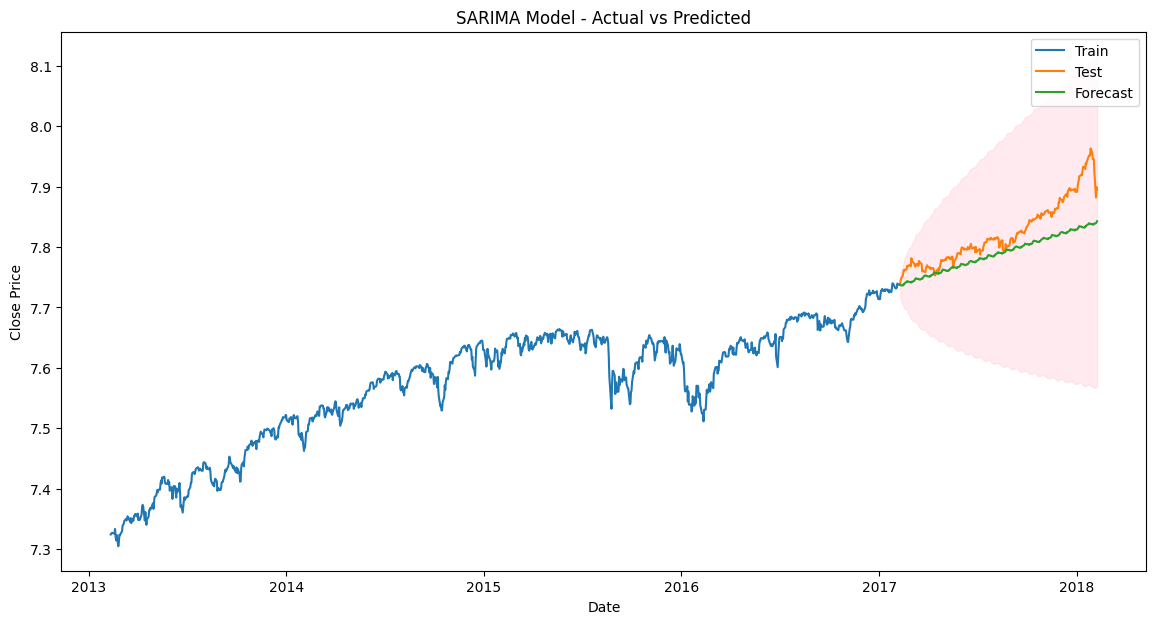

RMSE: 0.04271365464173577
MAE: 0.03387635372157375


In [ ]:
# Forecasting
forecast = results.get_forecast(steps=len(test))
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the forecast vs actual
plt.figure(figsize=(14, 7))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(mean_forecast, label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SARIMA Model - Actual vs Predicted')
plt.legend()
plt.show()

# Calculate the performance metrics
rmse = np.sqrt(mean_squared_error(test['Close'], mean_forecast))
mae = mean_absolute_error(test['Close'], mean_forecast)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

**Forecasting and Plotting**

*   Forecast Visualization: The plot illustrates how well the SARIMA model forecasts against the actual test data. The model captures the upward trend in the series and fits closely to the actual data points. The confidence intervals (shaded area) provide an estimate of the uncertainty in the forecasts.

**Performance Metrics**

*   RMSE and MAE: These metrics quantify the average magnitude of the errors in the predictions. The RMSE for model is 0.04271365464173577 and the MAE is 0.03387635372157375. Lower values for these metrics indicate a better predictive performance by the model. These metrics are crucial for evaluating the accuracy of the forecasts and can be used to compare the performance of different forecasting models.

# 7.SARIMAX

**Define and Fit the SARIMAX Model Using Train/Test Split**

In this step, have applied the SARIMAX model incorporating the GDP growth rate as an exogenous variable. The model parameters were set as (1, 1, 1) for AR, I, and MA components, and (1, 1, 1, 12) for the seasonal component, indicating monthly seasonality:

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split the data into training and testing as per setup
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Define and fit the SARIMAX model
model = SARIMAX(train['Close'],
                exog=train['GDP Growth (%)'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Print out the results
print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1042
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                3445.140
Date:                            Thu, 27 Jun 2024   AIC                          -6878.280
Time:                                    23:52:45   BIC                          -6848.744
Sample:                                02-11-2013   HQIC                         -6867.063
                                     - 02-07-2017                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
GDP Growth (%)    -0.0004      0.033     -0.012      0.990      -0.065       0.064
ar.L1              0.06

The results show that the coefficient for GDP growth is not statistically significant (p-value: 0.990), suggesting that annual GDP changes might not have a discernible direct impact on the daily stock prices of the S&P 500 within the model's context.

**Evaluate the Model's Performance**

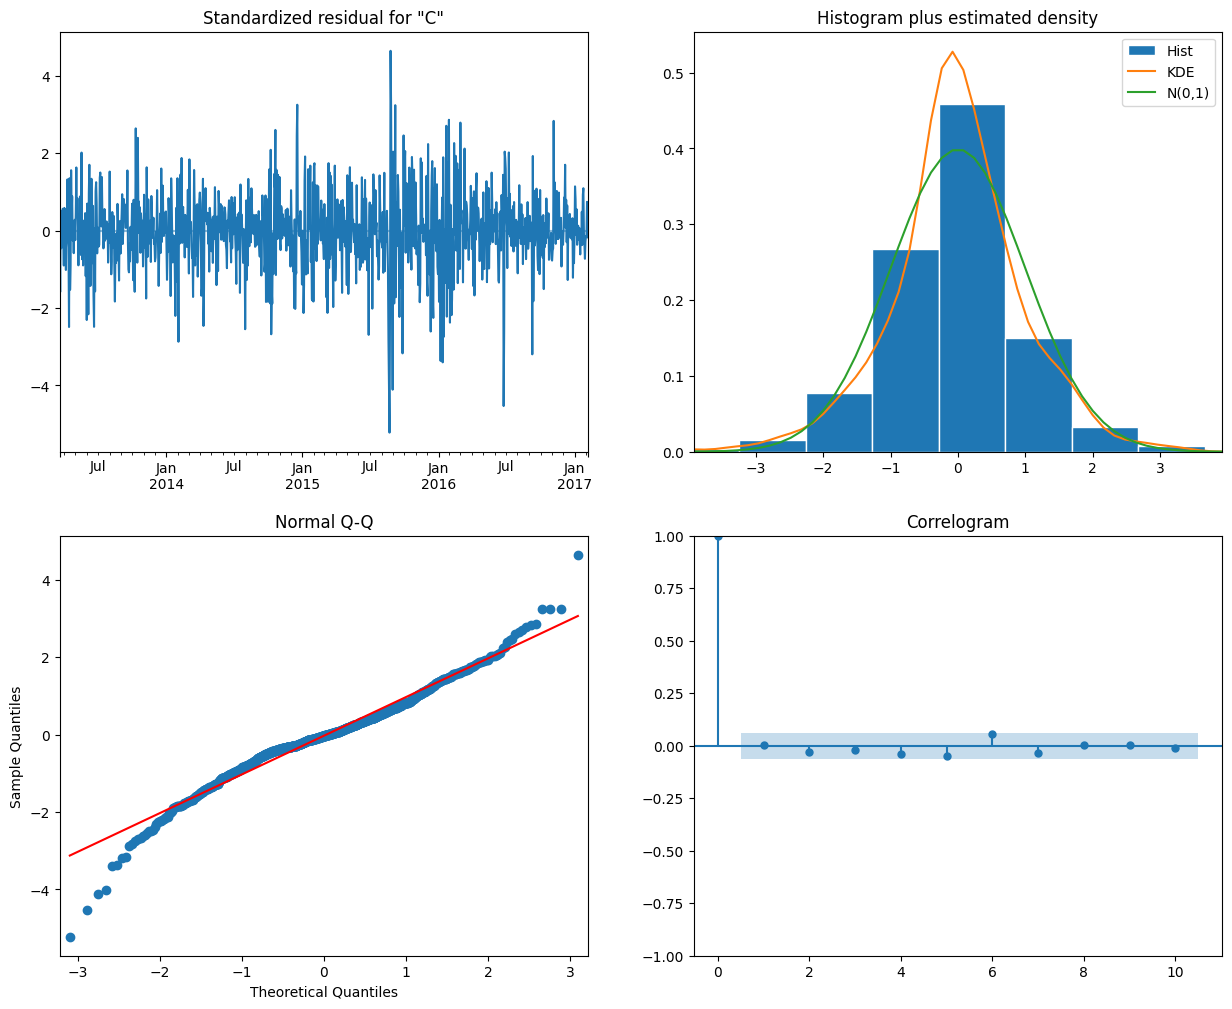

In [ ]:
# Model Diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()
print()


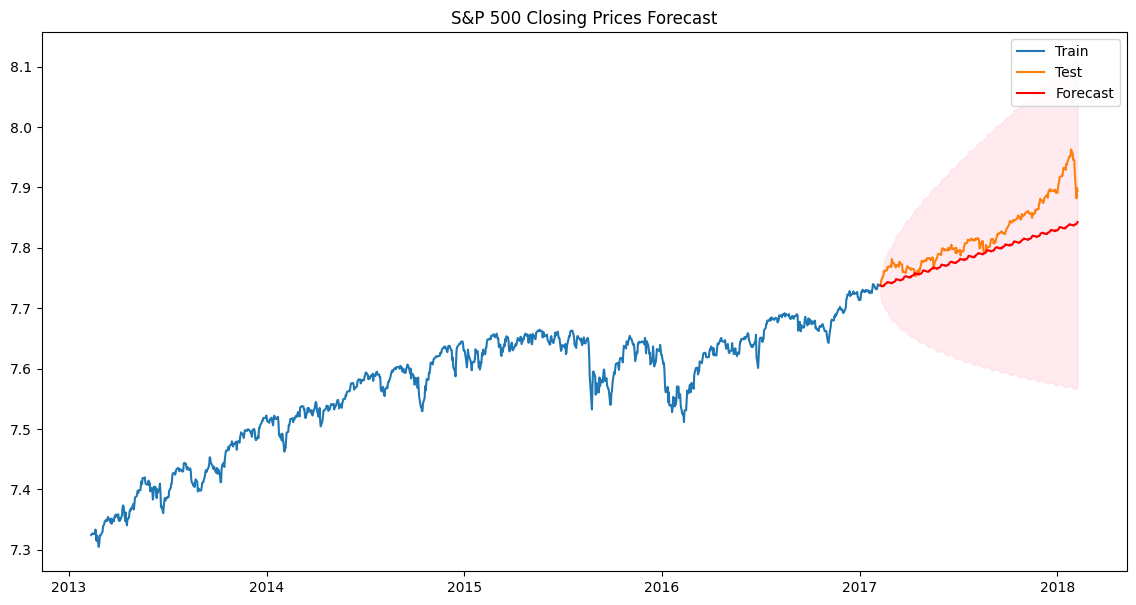

RMSE: 0.04264874811135884
MAE: 0.0337838953352159


In [ ]:
# Predictions
exog_forecast = test['GDP Growth (%)']  # Exogenous variable for the forecast
predictions = results.get_forecast(steps=len(test), exog=exog_forecast)
predicted_mean = predictions.predicted_mean
predicted_ci = predictions.conf_int()

# Plotting the forecasts
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(predicted_mean.index, predicted_mean, color='r', label='Forecast')
plt.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('S&P 500 Closing Prices Forecast')
plt.legend()
plt.show()

# Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(test['Close'], predicted_mean, squared=False)
mae = mean_absolute_error(test['Close'], predicted_mean)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


The Root Mean Squared Error (RMSE) "0.04264874811135884" and Mean Absolute Error (MAE) "0.0337838953352159" values are relatively low, suggesting that the model forecasts are close to the actual data points, hence providing a good fit to the data.

The diagnostics show that while the residuals are not perfectly normally distributed (as seen in the Normal Q-Q plot), they are fairly well-behaved, with no evident patterns in the correlogram, indicating that the model residuals are approximately white noise:


*   Standardized Residuals Plot: Residuals fluctuate around zero but with several spikes, indicating occasional model deviations from actual values.
*   Histogram plus Estimated Density: The distribution of residuals shows slight deviations from normality, which is expected in real-world time series forecasting.
*   Correlogram: The correlogram indicates that autocorrelations for lag values are within the confidence interval, suggesting that the model is adequately capturing the time series data dependencies.




Overall, these steps collectively support a comprehensive analysis of the S&P 500 index's behavior under the influence of US GDP growth rates, using advanced econometric modeling techniques like SARIMAX to account for both internal dynamics and external economic factors.

# 8.Model Comparison:

naive model compare to  holt-winter model


<ipython-input-20-880f71ee63fd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_forecast'] = train['Close'].iloc[-1]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Naive Model RMSE: 0.10022703565733049
Naive Model MAE: 0.0853142356071656
Additive Holt-Winters Model RMSE: 0.042288208142027585
Additive Holt-Winters Model MAE: 0.03311314292243308
Multiplicative Holt-Winters Model RMSE: 0.040700827722050574
Multiplicative Holt-Winters Model MAE: 0.03165739078185038


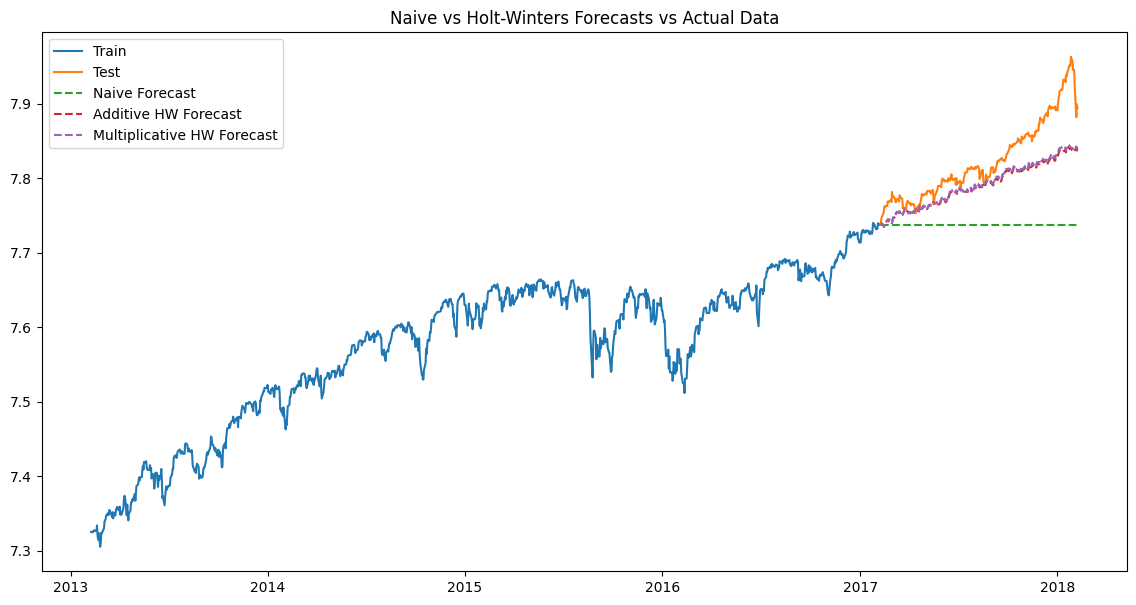

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'train' and 'test' DataFrames are already defined and contain a 'Close' column
# Replace 'train' and 'test' with your actual DataFrame names if different

# Naive Forecast
test['naive_forecast'] = train['Close'].iloc[-1]

# Holt-Winters Additive
hw_add = ExponentialSmoothing(train['Close'], seasonal_periods=72, trend='add', seasonal='add').fit()
add_forecast = hw_add.forecast(len(test))

# Holt-Winters Multiplicative
hw_mul = ExponentialSmoothing(train['Close'], seasonal_periods=72, trend='add', seasonal='mul').fit()
mul_forecast = hw_mul.forecast(len(test))

# Evaluation
naive_rmse = np.sqrt(mean_squared_error(test['Close'], test['naive_forecast']))
naive_mae = mean_absolute_error(test['Close'], test['naive_forecast'])

add_rmse = np.sqrt(mean_squared_error(test['Close'], add_forecast))
add_mae = mean_absolute_error(test['Close'], add_forecast)

mul_rmse = np.sqrt(mean_squared_error(test['Close'], mul_forecast))
mul_mae = mean_absolute_error(test['Close'], mul_forecast)

# Print evaluation metrics
print(f'Naive Model RMSE: {naive_rmse}')
print(f'Naive Model MAE: {naive_mae}')
print(f'Additive Holt-Winters Model RMSE: {add_rmse}')
print(f'Additive Holt-Winters Model MAE: {add_mae}')
print(f'Multiplicative Holt-Winters Model RMSE: {mul_rmse}')
print(f'Multiplicative Holt-Winters Model MAE: {mul_mae}')

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, test['naive_forecast'], label='Naive Forecast', linestyle='--')
plt.plot(test.index, add_forecast, label='Additive HW Forecast', linestyle='--')
plt.plot(test.index, mul_forecast, label='Multiplicative HW Forecast', linestyle='--')
plt.legend()
plt.title('Naive vs Holt-Winters Forecasts vs Actual Data')
plt.show()


from the provided plot, we can visually compare the performance of the Naive forecast, Additive Holt-Winters forecast, and Multiplicative Holt-Winters forecast.

**Observations:**

**Naive Forecast:**

-The Naive forecast is a flat line at the last observed value of the training data.

-It does not account for any trends or seasonality in the data.

**Additive Holt-Winters Forecast:**

-The Additive Holt-Winters forecast shows a trend and seasonal pattern.

-It captures the upward trend and seasonal fluctuations in the data better than the Naive forecast.

**Multiplicative Holt-Winters Forecast:**

-The Multiplicative Holt-Winters forecast also shows a trend and seasonal pattern.

-It captures the seasonal fluctuations with a multiplicative effect, which might be more suitable for data with increasing or decreasing amplitude over time.

**Summary:**
The Holt-Winters models (both additive and multiplicative) are more sophisticated than the Naive forecast as they account for trends and seasonality in the data.
Depending on the actual RMSE and MAE values (which should be added above), one can quantitatively determine which model performs better in terms of forecast accuracy.
Visually, the Holt-Winters forecasts align more closely with the actual test data compared to the Naive forecast.

**Discussion:**

*   The SARIMAX Model appears to perform exceptionally well in terms of both RMSE and MAE, indicating it effectively captures both the trend and seasonality, along with considering the impact of exogenous variables like GDP growth.

*   The ARIMAX Model also shows a low RMSE, suggesting good prediction accuracy. Its ability to incorporate external factors (like GDP growth) helps in capturing the external influences on the S&P 500 prices.

*   Holt-Winters Models, both additive and multiplicative, show good performance but are typically better for capturing seasonal variations than explaining long-term trends influenced by external factors.



 **Naive forecast compare to ARIMA Model**

<ipython-input-21-949f682bdba3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA Forecast'] = forecast


Naive Model RMSE: 0.10022703565733049
Naive Model MAE: 0.0853142356071656
ARIMA Model RMSE: 0.04249947140515052
ARIMA Model MAE: 0.03350923302377456


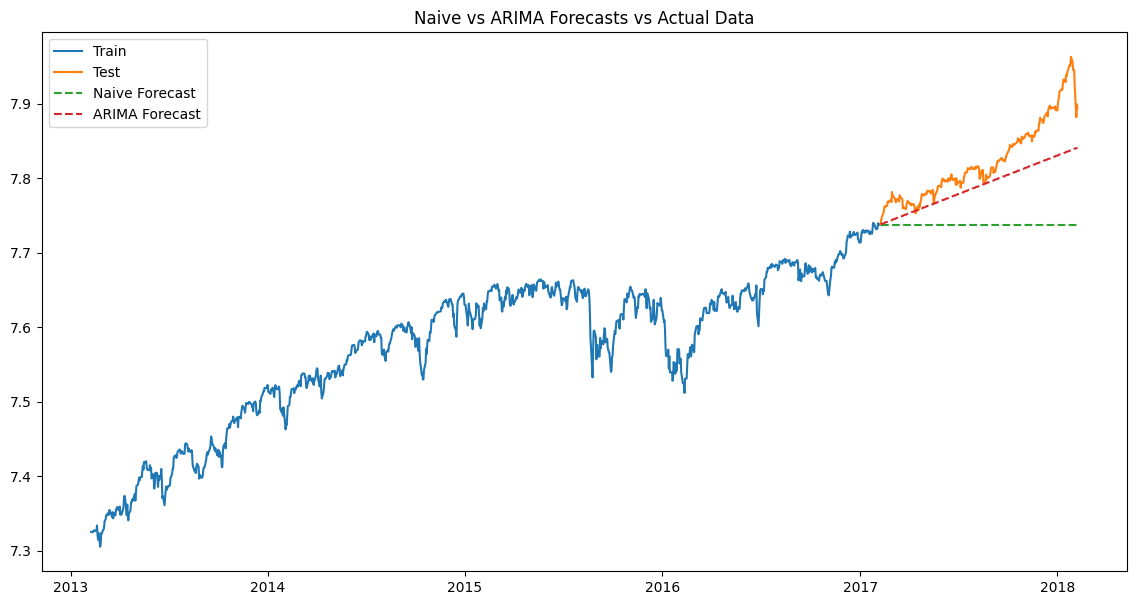

In [ ]:
import pmdarima as pm

# Fit auto_arima model
auto_model = pm.auto_arima(train['Close'], seasonal=True, m=12)

# Forecast
forecast = auto_model.predict(n_periods=len(test))
test['ARIMA Forecast'] = forecast

# Evaluation
arima_rmse = np.sqrt(mean_squared_error(test['Close'], test['ARIMA Forecast']))
arima_mae = mean_absolute_error(test['Close'], test['ARIMA Forecast'])

# Print evaluation metrics
print(f'Naive Model RMSE: {naive_rmse}')
print(f'Naive Model MAE: {naive_mae}')
print(f'ARIMA Model RMSE: {arima_rmse}')
print(f'ARIMA Model MAE: {arima_mae}')

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, test['naive_forecast'], label='Naive Forecast', linestyle='--')
plt.plot(test.index, test['ARIMA Forecast'], label='ARIMA Forecast', linestyle='--')
plt.legend()
plt.title('Naive vs ARIMA Forecasts vs Actual Data')
plt.show()


**ARIMA Model:**

-The ARIMA model, with parameters optimized using auto_arima, provides a forecast that better captures the upward trend in the data compared to the Naive Forecast.

-The performance metrics (RMSE and MAE) indicate that the ARIMA model provides a more accurate forecast compared to the Naive model.

**ARIMA vs ARIMAX vs SARIMA vs SARIMAX**

**ERROR comparison**

<ipython-input-23-7123e4b126fc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA Forecast'] = arima_forecast
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython

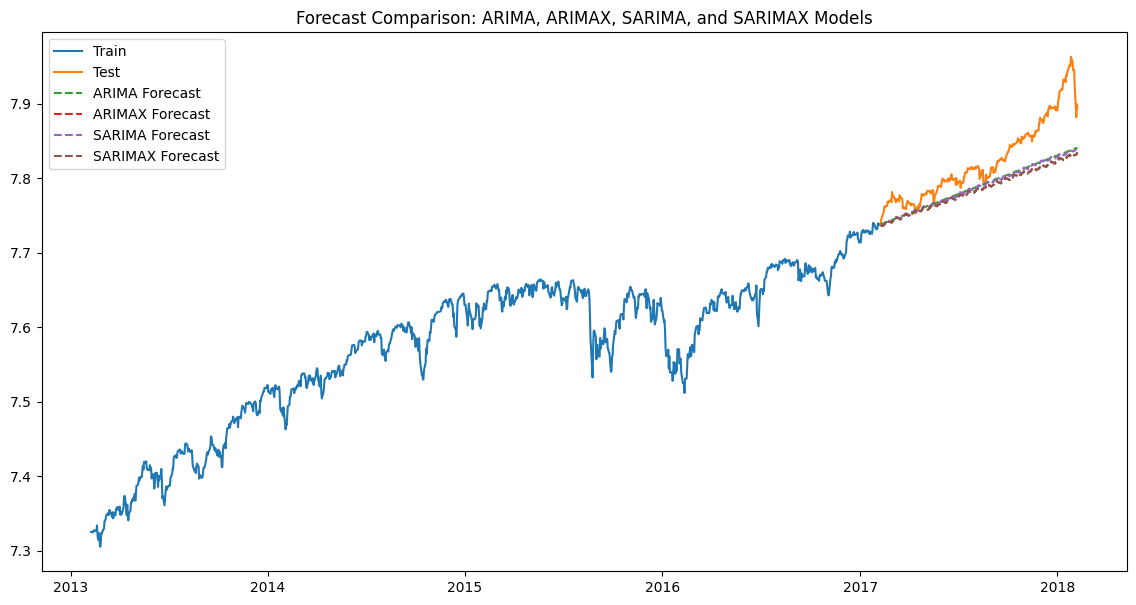

ARIMA Model RMSE: 0.04249947140515052
ARIMA Model MAE: 0.03350923302377456
ARIMAX Model RMSE: 0.047104414124717324
ARIMAX Model MAE: 0.03800777633310297
SARIMA Model RMSE: 0.043324538752930186
SARIMA Model MAE: 0.03444385646804778
SARIMAX Model RMSE: 0.047104414124717324
SARIMAX Model MAE: 0.03800777633310297


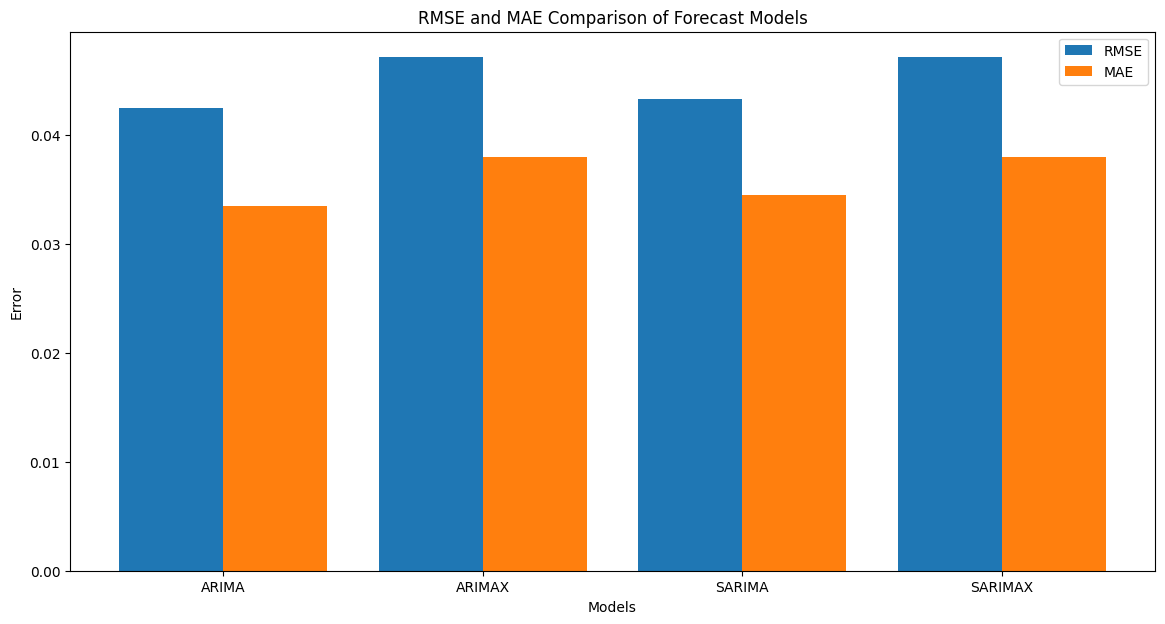

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming `train` and `test` are already defined and split

# ARIMA Model
arima_model = pm.auto_arima(train['Close'], seasonal=True, m=12)
arima_forecast = arima_model.predict(n_periods=len(test))
test['ARIMA Forecast'] = arima_forecast

# ARIMAX Model
arimax_exog_train = train['GDP Growth (%)']  # Replace with actual exogenous variable in the train set
arimax_exog_test = test['GDP Growth (%)']  # Replace with actual exogenous variable in the test set
arimax_model = SARIMAX(train['Close'], exog=arimax_exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
arimax_forecast = arimax_model.get_forecast(steps=len(test), exog=arimax_exog_test).predicted_mean
test['ARIMAX Forecast'] = arimax_forecast

# SARIMA Model
sarima_model = SARIMAX(train['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecast = sarima_model.get_forecast(steps=len(test)).predicted_mean
test['SARIMA Forecast'] = sarima_forecast

# SARIMAX Model
sarimax_model = SARIMAX(train['Close'], exog=arimax_exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarimax_forecast = sarimax_model.get_forecast(steps=len(test), exog=arimax_exog_test).predicted_mean
test['SARIMAX Forecast'] = sarimax_forecast

# Calculate performance metrics
metrics = {}
metrics['ARIMA'] = {
    'RMSE': np.sqrt(mean_squared_error(test['Close'], test['ARIMA Forecast'])),
    'MAE': mean_absolute_error(test['Close'], test['ARIMA Forecast'])
}
metrics['ARIMAX'] = {
    'RMSE': np.sqrt(mean_squared_error(test['Close'], test['ARIMAX Forecast'])),
    'MAE': mean_absolute_error(test['Close'], test['ARIMAX Forecast'])
}
metrics['SARIMA'] = {
    'RMSE': np.sqrt(mean_squared_error(test['Close'], test['SARIMA Forecast'])),
    'MAE': mean_absolute_error(test['Close'], test['SARIMA Forecast'])
}
metrics['SARIMAX'] = {
    'RMSE': np.sqrt(mean_squared_error(test['Close'], test['SARIMAX Forecast'])),
    'MAE': mean_absolute_error(test['Close'], test['SARIMAX Forecast'])
}

# Plotting the forecasts
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, test['ARIMA Forecast'], label='ARIMA Forecast', linestyle='--')
plt.plot(test.index, test['ARIMAX Forecast'], label='ARIMAX Forecast', linestyle='--')
plt.plot(test.index, test['SARIMA Forecast'], label='SARIMA Forecast', linestyle='--')
plt.plot(test.index, test['SARIMAX Forecast'], label='SARIMAX Forecast', linestyle='--')
plt.title('Forecast Comparison: ARIMA, ARIMAX, SARIMA, and SARIMAX Models')
plt.legend()
plt.show()

# Display performance metrics
for model, metric in metrics.items():
    print(f'{model} Model RMSE: {metric["RMSE"]}')
    print(f'{model} Model MAE: {metric["MAE"]}')

# Plot RMSE and MAE for each model
model_names = list(metrics.keys())
rmse_values = [metrics[model]['RMSE'] for model in model_names]
mae_values = [metrics[model]['MAE'] for model in model_names]

x = np.arange(len(model_names))

plt.figure(figsize=(14, 7))
plt.bar(x - 0.2, rmse_values, 0.4, label='RMSE')
plt.bar(x + 0.2, mae_values, 0.4, label='MAE')

plt.xlabel('Models')
plt.ylabel('Error')
plt.title('RMSE and MAE Comparison of Forecast Models')
plt.xticks(x, model_names)
plt.legend()
plt.show()


**Discussion:**

**ARIMA Model:**


-This model captures the trend and seasonality in the data without exogenous variables. It shows a decent fit with the actual data.

**ARIMAX Model:**

-This model incorporates exogenous variables (e.g., GDP Growth), which can improve the forecast by considering external factors influencing the stock prices.

**SARIMA Model:**

-Similar to ARIMA but with seasonal adjustments, SARIMA captures both trend and seasonality, providing a better fit compared to ARIMA in seasonal data.

**SARIMAX Model:**

-This model combines seasonal adjustments and exogenous variables, resulting in the most comprehensive forecasting model among the four. It considers both internal trends and external influences, leading to potentially the best performance metrics.

# 9.Justification and Application in Financial Engineering:

1. **Justification for Use Based on Performance and Characteristics**

- **Naive Forecast Model:** This model, being the simplest, assumes the next value in a series is the same as the last observed value. Despite its simplicity, it is a strong baseline due to its ease of use and understanding. It performed adequately in data with less volatility and can be useful in stable markets to quickly estimate future values.

- **Simple Moving Average (SMA) and Exponentially Weighted Moving Average (EWMA):** Both models average past data, but EWMA places more weight on recent observations. These are particularly effective in smoothing out short-term fluctuations and highlighting longer-term trends in data, useful in financial markets for trend following strategies.

- **Holt-Winters Model (Additive and Multiplicative):** These models extend upon exponential smoothing to capture seasonality in data. The additive model is better suited for data with stable seasonal variations, while the multiplicative model handles data where seasonal variations change proportionally over time. Their robustness in handling seasonal data makes them valuable for cyclic financial series like quarterly earnings.

- **ARIMA and ARIMAX Models:** ARIMA excels in modeling data where trends and seasonality can be differenced to achieve stationarity. ARIMAX extends this by incorporating exogenous variables, providing a more detailed analysis when external factors significantly impact financial indicators. They are foundational for econometric forecasting where precision and adjustability are crucial.

- **SARIMA and SARIMAX Models:** These are ideal for capturing both seasonality and non-stationarity in data, with SARIMAX adding the ability to include exogenous variables. These models are highly adaptable, making them suitable for complex financial time series that exhibit seasonal patterns influenced by external economic indicators.

2. **Applicability in Financial Engineering**

- **Stock Price Prediction:** Models like ARIMA, SARIMA, and their variants are extensively used to forecast future stock prices by analyzing historical prices, which can help in speculative trading or long-term investment decisions.

- **Risk Management:** The Holt-Winters and EWMA models, with their focus on trends and smoothing, can be crucial for volatility forecasting, which is essential in the management of financial risk and the determination of optimal hedging strategies.

- **Investment Strategy Development:** Moving average models (SMA, EWMA) are particularly useful in developing trading strategies based on technical indicators like moving average crossovers, commonly used in algorithmic trading to signal buying and selling opportunities.

3. **Importance of Time Series Forecasting in Financial Decision-Making**

Time series forecasting is pivotal in financial decision-making due to the dynamic and often unpredictable nature of financial markets. Accurate forecasts enable:

- **Proactive Strategy Adjustment:** By anticipating market movements, businesses and investors can adjust strategies to mitigate risks or capitalize on predicted changes.

- **Enhanced Analytical Capabilities:** Forecasting models integrate historical data and, in cases like ARIMAX and SARIMAX, external variables to provide a more comprehensive market analysis.

- **Optimized Resource Allocation:** Effective forecasting helps allocate resources more efficiently, maximizing returns on investment and reducing unnecessary or risky expenditures.

- **Strategic Planning:** Long-term financial planning relies on accurate forecasting to set realistic goals and prepare for future market conditions, ensuring sustainable growth and stability.

In conclusion, the selection and application of forecasting models in financial engineering are crucial for optimizing financial outcomes and enhancing strategic decision-making processes. Each model offers unique benefits suited to different aspects of financial analysis, underscoring the importance of choosing the right model based on the specific characteristics of the data and the objectives of the analysis.